In [113]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as plt
import math
import numpy as np
import lightgbm as lgb

plt.rcParams['figure.dpi'] = 200

from scipy.special import expit, logit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import auc, mean_squared_error, roc_curve, roc_auc_score

from sklearn import preprocessing

%matplotlib inline

# Load Data

In [114]:
dir_path = os.path.join(os.getcwd(), 'hw4_data_files')
path1 = os.path.join(dir_path,'data1.csv')
path2 = os.path.join(dir_path,'data2.csv')

data1 = pd.read_csv(path1,index_col=0)
data2 = pd.read_csv(path2,index_col=0)

## Turn catagorial data into one-hot vectors

In [115]:
dummy_data1 = pd.get_dummies(data1[['x_2','x_21','x_24']])
dummy_data1 = dummy_data1.reset_index()
data1_adj = data1.drop(columns=['x_2','x_21','x_24']).reset_index()

dummy_data2 = pd.get_dummies(data2[['x_2','x_21','x_24']])
dummy_data2 = dummy_data2.reset_index()
data2_adj = data2.drop(columns=['x_2','x_21','x_24']).reset_index()

data11 = pd.merge(data1_adj,dummy_data1, on='index')
data21 = pd.merge(data2_adj,dummy_data2, on='index')

data11.drop(columns=['index'],inplace=True)
data21.drop(columns=['index'],inplace=True)

cols_to_drop = ['T','Y']
X1 = data11.drop(columns=cols_to_drop)
Y1 = data11['Y']
T1 = data11['T']

X11 = data11[data11['T']==1].drop(columns=cols_to_drop)
Y11 = data11[data11['T']==1].Y

X2 = data21.drop(columns=cols_to_drop)
Y2 = data21['Y']
T2 = data21['T']

X21 = data21[data21['T']==1].drop(columns=cols_to_drop)
Y21 = data21[data21['T']==1].Y


## Propensity Score - using Logistic Regression  

In [116]:
def calc_propensity_score_sklearn_LR(X,T):

    model = LogisticRegression(max_iter=500)
    ps_model = model.fit(X=X, y=T)
    pscores = ps_model.predict_proba(X)[:,1]
    
    return ps_model, pscores
    
def plot_pscores(datasets, titles=['propensity score of data1 LR','propensity score of data2 LR']):
    ncols = len(datasets)
    fig, ax = plt.subplots(nrows=1,ncols=ncols, figsize=plt.figaspect(0.5))
    for i, data in enumerate(datasets):      
        labels = [0,1]
        data_0 = data[data['T']==0]
        data_1 = data[data['T']==1]
        N_0 = data_0.shape[0]
        N_1 = data_1.shape[0]
        
        pscores_treated = data_1.ps
        ax[i] = sns.kdeplot(pscores_treated, shade=True, label=f'T={labels[1]} N=({N_1})', ax=ax[i])
        pscores_not_treated = data_0.ps
        ax[i] = sns.kdeplot(pscores_not_treated, shade=True, label=f'T={labels[0]} N=({N_0})', ax=ax[i])
        ax[i].set_title(titles[i])
        ax[i].legend(loc="best")

In [117]:
ps_model1, pscores = calc_propensity_score_sklearn_LR(X=X1, T=T1)
data1_copy = data11.copy()
data1_copy['ps'] = pscores


ps_model2, pscores = calc_propensity_score_sklearn_LR(X=X2, T=T2)
data2_copy = data2.copy()
data2_copy['ps'] = pscores

/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

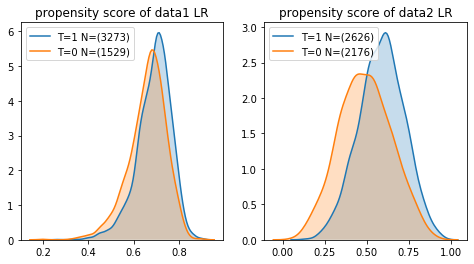

In [118]:
plot_pscores(datasets=[data1_copy,data2_copy])

# Matching 

In [119]:
def find_propensity_score_matches(X, TX_col, pscore_col, caliper=0.25, distance='linear'):
    """
    Treatment group should be smaller
    """
    
    idx_A0 = X[TX_col]==0
    idx_A1 = X[TX_col]==1
    
    X_T1, X_T0 = X[idx_A1].copy(), X[idx_A0].copy()
    N1, N0 = len(X_T1), len(X_T0)
    g1, g0 = X_T1.loc[:,pscore_col].copy(),  X_T0.loc[:,pscore_col].copy()
    
    # get caliper_value (default is 0.25 logit stdevs
    caliper_value = caliper * logit(X[pscore_col]).std()

    # Randomly permute the smaller group to get order for matching
    g1_idx_order = np.random.permutation(g1.index)
    for g1_idx in g1_idx_order:
        
        if distance=='linear': # linear propensity score (on the logits)
            dist = np.abs(logit(g1[g1_idx]) - logit(g0))
        else: # regular propensity score
            dist = np.abs(g1[g1_idx] - g0)
        
        
        if dist.min() <= caliper_value:
            g0_idx = dist.idxmin()
            X_T1.loc[g1_idx, 'matched_control_idx'] = g0_idx
            X_T0.loc[g0_idx, 'matched_control_idx'] = g0_idx
            g0 = g0.drop(g0_idx)
        else:
            X_T1.loc[g1_idx, 'matched_control_idx'] = np.nan        
            
    X_matched = pd.concat([X_T1, X_T0])
    return X_matched

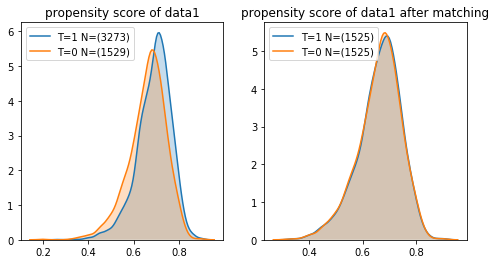

In [120]:
data11['ps'] = data1_copy.ps
data_matched = find_propensity_score_matches(data11, 'T', 'ps', caliper=0.25, distance='linear')
data_matched.dropna(subset=['matched_control_idx'],inplace=True)
plot_pscores(datasets=[data11,data_matched],titles=['propensity score of data1','propensity score of data1 after matching'])

/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


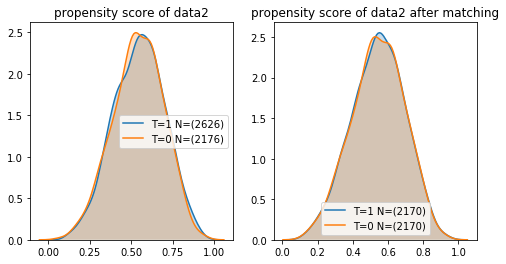

In [121]:
data21['ps'] = data2_copy.ps
data_matched2 = find_propensity_score_matches(data21, 'T', 'ps', caliper=0.25, distance='linear')
data_matched2.dropna(subset=['matched_control_idx'],inplace=True)
plot_pscores(datasets=[data21,data_matched2],titles=['propensity score of data2','propensity score of data2 after matching'])

### Saving propensity scores:

In [123]:
pd.DataFrame({'data1': data1_copy.ps, 'data2': data2_copy.ps}).T.to_csv(os.path.join(dir_path,'models propensity.csv'))

# Estimating ATT

In [324]:
ATT_pd = pd.DataFrame(columns=['Type','data1','data2'])
att_dict1 = {}
att_dict2 = {}

# Estimating ATT by Inverse Propensity Score Weighting (IPW)

Under ignorability for ATE we use the following formula:
\begin{equation}
\frac{1}{n}\sum_{i=1}^{n}{\frac{y_i t_i}{e_i}} - \frac{1}{n}\sum_{i=1}^{n}{\frac{y_i (1-t_i)}{1-e_i}}
\end{equation}

The weights described previously ($w_ATE= \frac{Z}{e} +\frac{1-Z}{1-e}$) permit estimation of the ATE. However, a different set of weights permit estimation of the average treatment effect in the treated (ATT): $w_ATT = Z +\frac{e \cdot(1−Z)}{1 − e}$[18]. These weights are obtained by multiplying the conventional weights by e , so that treated subjects receive a weight of one. Thus, the treated sample is being used as the reference population to which the treated and control samples are being standardized. While the current article is focused on the use of the ATE weights, the balance diagnostics discussed are equally applicable to situations in which the ATT weights are employed.

So We calculate:

\begin{equation}
\frac{1}{n}\sum_{i=1}^{n}{y_i t_i} - \frac{1}{n}\sum_{i=1}^{n}{y_i (1-t_i) \frac{e_i}{1-e_i}}
\end{equation}

In [428]:
ATE1 = (Y1*T1*(1/data1_copy.ps)).mean() - (Y1*(1-T1)*(1/(1-data1_copy.ps))).mean()
print(f"The estimated ATE for data1 using IPW is {ATE1}")
ATT1 = (Y1*T1).mean() - (Y1*(1-T1)*(data1_copy.ps/(1-data1_copy.ps))).mean()
print(f"The estimated ATT for data1 using IPW is {ATT1}")

att_dict1['IPW'] =ATT1

ATE2 = (Y2*T2*(1/data2_copy.ps)).mean() - (Y2*(1-T2)*(1/(1-data2_copy.ps))).mean()
print(f"The estimated ATE for data2 using IPW is {ATE2}")
ATT2 = (Y2*T2).mean() - (Y2*(1-T2)*(data2_copy.ps/(1-data2_copy.ps))).mean()
print(f"The estimated ATT for data2 using IPW is {ATT2}")

att_dict2['IPW'] =ATT2

The estimated ATE for data1 using IPW is 4.508278610497134
The estimated ATT for data1 using IPW is 2.9730169584388655
The estimated ATE for data2 using IPW is 4.468700232451579
The estimated ATT for data2 using IPW is 2.2010543359435957


# Estimating ATT using Matching

I use K-nearest neighbors as described here https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943670/ "..Nearest neighbor matching nearly always estimates the ATT, as it matches control individuals to the treated group and discards controls who are not selected as matches."

### Using Uber matching

In [326]:
from causalml.match import NearestNeighborMatch, create_table_one

psm = NearestNeighborMatch(replace=False,
                           ratio=1,
                           random_state=42)

features = data11.drop(columns='Y')
covariates = features.columns.tolist()

matched1 = psm.match(data=data11,treatment_col='T',score_cols=['ps'])
matched2 = psm.match(data=data21.dropna(),treatment_col='T',score_cols=['ps'])

In [327]:
ATT1 = (matched1.Y*matched1['T'] - matched1.Y*(1-matched1['T'])).mean()
print(f"The estimated ATT for data1 using 1:1 matching on ps is {ATT1}")
att_dict1['1:1 ps matching'] =ATT1
ATT2 = (matched2.Y*matched1['T'] - matched2.Y*(1-matched1['T'])).mean()
print(f"The estimated ATT for data1 using 1:1 matching on ps is {ATT2}")
att_dict2['1:1 ps matching'] =ATT2

The estimated ATT for data1 using 1:1 matching on ps is 2.3475052269636976
The estimated ATT for data1 using 1:1 matching on ps is -0.1305258166120302


### Using my code

In [328]:
ATT1 = (data_matched.Y*data_matched['T'] - data_matched.Y*(1-data_matched['T'])).mean()
print(f"The estimated ATT for data1 using 1:1 matching on ps is {ATT1}")
att_dict1['1:1 ps matching'] =ATT1
ATT2 = (data_matched2.Y*data_matched2['T'] - data_matched2.Y*(1-data_matched2['T'])).mean()
print(f"The estimated ATT for data1 using 1:1 matching on ps is {ATT2}")
att_dict2['1:1 ps matching'] =ATT2

The estimated ATT for data1 using 1:1 matching on ps is 2.361404406586158
The estimated ATT for data1 using 1:1 matching on ps is 1.9803656310744755


# Estimating ATT using S-Learner

S-learner (single): fit a model with $t$ as feature on the entire sample:
\begin{equation}
y \approx \hat{f}(x,t) \\
ATT \approx \frac{1}{n}\sum_{i=1}^{n}{\hat{f}(x,1)} - \frac{1}{n}\sum_{i=1}^{n}{\hat{f}(x,0)}
\end{equation}

In [329]:
train1, test1 = train_test_split(data11,test_size=0.33)
train2, test2 = train_test_split(data21,test_size=0.33)

x_train1, t_train1, y_train1 = train1.drop(columns=['T','Y']), train1['T'],train1['Y']
x_test1, t_test1, y_test1 = test1.drop(columns=['T','Y']), test1['T'],test1['Y']

x_train2, t_train2, y_train2 = train2.drop(columns=['T','Y']), train2['T'],train2['Y']
x_test2, t_test2, y_test2 = test2.drop(columns=['T','Y']), test2['T'],test2['Y']

## Begin by estimating most accurate model

### Linear approach

In [95]:
LR = LinearRegression()
LR_fit = LR.fit(x_train1.join(t_train1),y_train1)
mse1 = mean_squared_error(LR_fit.predict(x_test1.join(t_test1)),y_test1)
print(f"mse for test set data1 with LR is {mse1}")
LR_fit = LR.fit(x_train2.join(t_train2),y_train2)
mse2 = mean_squared_error(LR_fit.predict(x_test2.join(t_test2)),y_test2)
print(f"mse for test set data2 with LR is {mse2}")

mse for test set data1 with LR is 19.231872305687165
mse for test set data2 with LR is 29.383791498844538


### Random Forest

Hyper-parameter search

In [59]:
# Number of trees in random forest
n_estimators = [200,400,600,800]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3,5,10,20,30]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [97]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random1 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random1.fit(x_train1.join(t_train1),y_train1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [155]:
rf_random1.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [193]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mse = mean_squared_error(predictions,test_labels)
    print('Model Performance')
    print('MSE = {:0.2f}'.format(mse))
    
    return mse

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train1.join(t_train1),y_train1)
base_accuracy = evaluate(base_model, x_test1.join(t_test1),y_test1)


best_random = rf_random1.best_estimator_
random_accuracy = evaluate(best_random, x_test1.join(t_test1),y_test1)


Model Performance
MSE = 3.31
Model Performance
MSE = 2.87


In [202]:
base_model = RandomForestRegressor(n_estimators = 100, max_depth=20)
base_model.fit(x_train2.join(t_train2),y_train2)
base_accuracy = evaluate(base_model, x_test2.join(t_test2),y_test2)

Model Performance
MSE = 3.83


### GBM

In [414]:
GBM1 = GradientBoostingRegressor(n_estimators = 100, max_depth=5)
scores = cross_val_score(GBM1,x_train1.join(t_train1),y_train1,cv=5)
scores

array([0.94492897, 0.93449444, 0.94096299, 0.93471576, 0.94260635])

In [415]:
GBR = GBM1.fit(x_train1.join(t_train1),y_train1)

In [197]:
evaluate(GBR, x_test1.join(t_test1),y_test1 )

Model Performance
MSE = 1.86


1.8647834869912199

In [198]:
GBR2 = base_model.fit(x_train2.join(t_train2),y_train2)
evaluate(GBR2, x_test2.join(t_test2),y_test2 )

Model Performance
MSE = 2.66


2.6637855166372373

## Using best model (GBM) for estimating ATT

In [330]:
base_model = GradientBoostingRegressor(n_estimators = 100, max_depth=5)

In [416]:
base_model1 = GradientBoostingRegressor(n_estimators = 100, max_depth=5)
base_model2 = GradientBoostingRegressor(n_estimators = 100, max_depth=5)

GBR = base_model1.fit(X1.join(T1),Y1)
GBR2 = base_model2.fit(X2.join(T2),Y2)

In [332]:
X11t = X11.copy()
X11t['T']=1

X11nt = X11.copy()
X11nt['T']=0

X21t = X21.copy()
X21t['T']=1

X21nt = X21.copy()
X21nt['T']=0

In [417]:
ATT1 = (GBR.predict(X11t)-GBR.predict(X11nt)).mean()
print(f"The estimated ATT for data1 using S-learner (GBM) is {ATT1}")
att_dict1['S-learner (GBM)'] =ATT1

ATT2 = (GBR2.predict(X21t)-GBR2.predict(X21nt)).mean()
print(f"The estimated ATT for data2 using S-learner (GBM) is {ATT2}")
att_dict2['S-learner (GBM)'] =ATT2

The estimated ATT for data1 using S-learner (GBM) is 4.229103006643202
The estimated ATT for data2 using S-learner (GBM) is 2.2811383001007135


# Estimating ATT using T-Learner

T-learner (Two): fit a different model for treated and non-treated:
\begin{equation}
y_1 \approx \hat{f_1}(x,t), y_0 \approx \hat{f_0}(x,t)  \\
ATT \approx \frac{1}{n}\sum_{i=1}^{n}{\hat{f_1}(x_1,1)} - \frac{1}{n}\sum_{i=1}^{n}{\hat{f_0}(x_1,0)}
\end{equation}

In [410]:
base_model1 = GradientBoostingRegressor(n_estimators = 100, max_depth=5)
base_model2 = GradientBoostingRegressor(n_estimators = 100, max_depth=5)


In [411]:
treated1 = data11[data11['T']==1]
not_treated1 = data11[data11['T']==0]

GBR1_treated = base_model1.fit(treated1.drop(columns=['Y','ps','T']),treated1.Y)
GBR1_not_treated = base_model2.fit(not_treated1.drop(columns=['Y','ps','T']),not_treated1.Y)

ATT1 = (GBR1_treated.predict(treated1.drop(columns=['Y','ps','T']))-GBR1_not_treated.predict(treated1.drop(columns=['Y','ps','T']))).mean()

treated2 = data21[data21['T']==1]
not_treated2 = data21[data21['T']==0]

GBR2_treated = base_model1.fit(treated2.drop(columns=['Y','ps','T']),treated2.Y)
GBR2_not_treated = base_model2.fit(not_treated2.drop(columns=['Y','ps','T']),not_treated2.Y)

ATT2 = (GBR2_treated.predict(treated2.drop(columns=['Y','ps','T']))-GBR2_not_treated.predict(treated2.drop(columns=['Y','ps','T']))).mean()

In [412]:
print(f"The estimated ATT for data1 using T-learner (GBM) is {ATT1}")
att_dict1['T-learner (GBM)'] =ATT1

print(f"The estimated ATT for data2 using T-learner (GBM) is {ATT2}")
att_dict2['T-learner (GBM)'] =ATT2

The estimated ATT for data1 using T-learner (GBM) is 4.1701895371007245
The estimated ATT for data2 using T-learner (GBM) is 2.517100732742952


# Final ATT estimates

In [418]:
pdatt = pd.DataFrame.from_dict(att_dict1,orient='index', columns=['data1'])
pdatt['data2'] = pdatt.index.map(att_dict2)

pdatt

,data1,data2
IPW,2.973017,2.201054
1:1 ps matching,2.361404,1.980366
S-learner (GBM),4.229103,2.281138
T-learner (GBM),4.170190,2.517101


# MY Model for estimating ATT

In [437]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel


In [439]:
from xgboost import XGBRegressor

In [445]:
# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X1, treatment=T1, y=Y1, p=data11['ps'])


[10:43:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:43:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [451]:
print(f"The estimated ATT for data1 using X-learner (XGboost) is {cate_x.mean()}")
att_dict1['X-learner (XGboost)'] =cate_x.mean()

The estimated ATT for data1 using X-learner (XGboost) is 4.457749564689987


In [461]:
# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X2.drop(index=0), treatment=T2.drop(index=0), y=Y2.drop(index=0), p=data21['ps'].drop(index=0))


[10:51:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [462]:
print(f"The estimated ATT for data1 using X-learner (XGboost) is {cate_x.mean()}")
att_dict2['X-learner (XGboost)'] =cate_x.mean()

The estimated ATT for data1 using X-learner (XGboost) is 2.474191716143296


In [464]:
pdatt = pd.DataFrame.from_dict(att_dict1,orient='index', columns=['data1'])
pdatt['data2'] = pdatt.index.map(att_dict2)

,data1,data2
IPW,2.973017,2.201054
1:1 ps matching,2.361404,1.980366
S-learner (GBM),4.229103,2.281138
T-learner (GBM),4.170190,2.517101
X-learner (XGboost),4.457750,2.474192


In [465]:
pdatt.to_csv(os.path.join(dir_path,'ATT results.csv'))